In [43]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path
import numpy 
import pickle
from glob import glob
import matplotlib.pyplot as plt

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)
        print(self.inputs.shape)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

(11993, 50, 2)


In [21]:
batch_sz = 5
train_loader_pa = DataLoader(train_dataset,batch_size=batch_sz)

In [4]:
for i_batch, sample_batch in train_loader_pa:
    test = sample_batch
    break

In [5]:
import numpy as np

class KalmanFilter(object):
    def __init__(self, dt, u_x, u_y, std_acc, x_std_meas, y_std_meas):
        """
        :param dt: sampling time
        :param u_x: accel in x-direction
        :param u_y: accel in y-direction
        :param std_acc: process noise magnitude
        :param x_std_meas: sd of the measurement in x-direction
        :param y_std_meas: sd of the measurement in y-direction
        """

        # Sampling time
        self.dt = dt

        # Control input variables
        self.u = np.matrix([[u_x], [u_y]])

        # Initial State
        self.x = np.matrix([[0.], [0], [0], [0]])

        # State Transition Matrix A
        self.A = np.matrix([[1., 0, self.dt, 0],
                            [0, 1, 0, self.dt],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]])

        # Control Input Matrix B
        self.B = np.matrix([[(self.dt ** 2) / 2, 0.],
                            [0, (self.dt ** 2) / 2],
                            [self.dt, 0],
                            [0, self.dt]])

        # Measurement Mapping Matrix
        self.H = np.matrix([[1., 0, 0, 0],
                            [0, 1, 0, 0]])

        # Process Noise Covariance
        self.Q = np.matrix([[(self.dt ** 4) / 4, 0., (self.dt ** 3) / 2, 0],
                            [0, (self.dt ** 4) / 4, 0, (self.dt ** 3) / 2],
                            [(self.dt ** 3) / 2, 0, self.dt ** 2, 0],
                            [0, (self.dt ** 3) / 2, 0,
                             self.dt ** 2]]) * std_acc ** 2

        # Measurement Noise Covariance
        self.R = np.matrix([[x_std_meas ** 2, 0.],
                            [0, y_std_meas ** 2]])

        # Covariance Matrix
        self.P = np.eye(4)

    def predict(self):
        # Update time state
        self.x = np.dot(self.A, self.x) + np.dot(self.B, self.u)

        # Calculate error covariance
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
        return self.x[0]

    def update(self, z):
        # S = H*P*H'+R
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R

        # Calculate the Kalman Gain
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))

        self.x = np.round(
            self.x + np.dot(K, (z - np.dot(self.H, self.x))))

        # Update error covariance matrix
        self.P = (np.eye(self.H.shape[1]) - (K * self.H)) * self.P
        return self.x[0]

In [6]:
def get_traj_pred(test_traj_in, num_pred_steps):
    final_array = np.zeros((len(test_traj_in), num_pred_steps, 2))
    for i in range(len(test_traj_in)):
        KF = KalmanFilter(0.1, 1, 1, 1, 0.1,0.1)
        for j in test_traj_in[i]:
            KF.predict()
            KF.update(j)
        for k in range(num_pred_steps):
            final_array[i, k] = KF.predict()
    return final_array

In [35]:
def create_random_plot():
    for i_batch, sample_batch in enumerate(train_loader_pa):
        rand = np.random.randint(batch_sz, size=1)
        inp, out = sample_batch
        preds = get_traj_pred(inp, 60)
        plt.scatter(x=inp[rand,:,0],y=inp[rand,:,1], color="red", alpha=0.5, label="Input Points")
        plt.scatter(x=out[rand,:,0],y=out[rand,:,1], color="blue", alpha=0.5, label="Ground Truth")
        plt.scatter(x=preds[rand,:,0],y=preds[rand,:,1], color="green", alpha=0.5, label="Predictions")
        plt.legend()
        plt.show()
        break

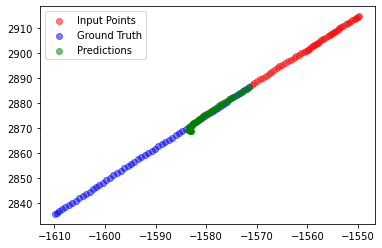

In [42]:
create_random_plot()

In [7]:
num_pred_steps = 60
all_preds = np.zeros(shape=(0, num_pred_steps * 2))
city_col = np.array([])

for city_name in cities:
    
    print("Processing city", city_name)
    
    test_traj_in, test_traj_out = get_city_trajectories(city=city_name, split="test")
    print(test_traj_in.shape)
    
    test_pred_arr = get_traj_pred(test_traj_in, num_pred_steps)
    print(test_pred_arr.shape)
    
    test_pred_arr_reshaped = np.reshape(test_pred_arr, newshape = (test_traj_in.shape[0], num_pred_steps * 2))
    print(test_pred_arr_reshaped.shape)
    
    all_preds = np.r_[all_preds, test_pred_arr_reshaped]
    city_col = np.r_[city_col, [str(i) + "_" + city_name for i in range(test_pred_arr.shape[0])]]

Processing city austin
(6325, 50, 2)
(6325, 60, 2)
(6325, 120)
Processing city miami
(7971, 50, 2)
(7971, 60, 2)
(7971, 120)
Processing city pittsburgh
(6361, 50, 2)
(6361, 60, 2)
(6361, 120)
Processing city dearborn
(3671, 50, 2)
(3671, 60, 2)
(3671, 120)
Processing city washington-dc
(3829, 50, 2)
(3829, 60, 2)
(3829, 120)
Processing city palo-alto
(1686, 50, 2)
(1686, 60, 2)
(1686, 120)


In [8]:
import pandas as pd
sub_df = pd.DataFrame(np.c_[city_col, all_preds], columns = [np.r_[["ID"],["v" + str(i) for i in range(120)]]])

In [9]:
sub_df

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-12.594999999999999,-566.495,-13.179999999999998,-565.98,-13.754999999999997,-565.455,-14.319999999999997,-564.9200000000001,-14.874999999999996,...,-29.92000000000007,-523.3200000000004,-29.95500000000007,-522.2550000000005,-29.98000000000007,-521.1800000000004,-29.995000000000072,-520.0950000000004,-30.000000000000075,-519.0000000000003
1,1_austin,-344.495,11.605,-343.98,11.22,-343.45500000000004,10.845,-342.9200000000001,10.480000000000002,-342.37500000000006,...,-301.32000000000033,5.280000000000012,-300.25500000000034,5.445000000000012,-299.18000000000035,5.620000000000012,-298.09500000000037,5.805000000000012,-297.0000000000004,6.000000000000012
2,2_austin,51.305,-247.995,51.620000000000005,-247.98000000000002,51.94500000000001,-247.955,52.28000000000001,-247.92000000000002,52.625000000000014,...,83.47999999999992,-232.32000000000025,84.34499999999991,-231.75500000000025,85.21999999999991,-231.18000000000026,86.1049999999999,-230.59500000000025,86.9999999999999,-230.00000000000026
3,3_austin,-113.595,1798.4050000000002,-113.18,1798.8200000000004,-112.75500000000001,1799.2450000000006,-112.32000000000001,1799.6800000000007,-111.87500000000001,...,-75.9200000000003,1836.0800000000065,-74.95500000000031,1837.0450000000067,-73.98000000000032,1838.0200000000068,-72.99500000000032,1839.005000000007,-72.00000000000033,1840.000000000007
4,4_austin,1196.4050000000002,-637.395,1197.8200000000004,-637.78,1199.2450000000006,-638.155,1200.6800000000007,-638.52,1202.125000000001,...,1289.0800000000065,-643.7200000000003,1291.0450000000067,-643.5550000000003,1293.0200000000068,-643.3800000000003,1295.005000000007,-643.1950000000004,1297.000000000007,-643.0000000000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,1681_palo-alto,-1391.495,-478.195,-1391.9799999999998,-479.38,-1392.4549999999997,-480.555,-1392.9199999999996,-481.72,-1393.3749999999995,...,-1403.319999999994,-528.5200000000002,-1403.254999999994,-529.1550000000002,-1403.179999999994,-529.7800000000002,-1403.094999999994,-530.3950000000002,-1402.9999999999939,-531.0000000000002
29839,1682_palo-alto,129.405,-21.395,129.82,-20.78,130.24499999999998,-20.155,130.67999999999998,-19.520000000000003,131.12499999999997,...,167.07999999999967,27.27999999999994,168.04499999999967,28.444999999999936,169.01999999999967,29.619999999999933,170.00499999999965,30.804999999999932,170.99999999999966,31.99999999999993
29840,1683_palo-alto,-1436.5949999999998,2161.605,-1436.1799999999996,2161.2200000000003,-1435.7549999999994,2160.8450000000003,-1435.3199999999993,2160.4800000000005,-1434.874999999999,...,-1398.9199999999935,2155.280000000006,-1397.9549999999933,2155.445000000006,-1396.9799999999932,2155.6200000000063,-1395.994999999993,2155.805000000006,-1394.999999999993,2156.0000000000064
29841,1684_palo-alto,1071.505,1398.505,1072.0200000000002,1399.0200000000002,1072.5450000000003,1399.5450000000003,1073.0800000000004,1400.0800000000004,1073.6250000000005,...,1114.680000000006,1441.680000000006,1115.745000000006,1442.745000000006,1116.820000000006,1443.820000000006,1117.905000000006,1444.905000000006,1119.0000000000061,1446.0000000000061


In [10]:
sub_df.to_csv("second_sub.csv", index=None)